In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

import pandas as pd

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

In [2]:
from HFC32_emimTf2N_PR3 import configuration
data = pd.read_csv('R32_emimTf2N.csv')

solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

data_283 = data[(data.temperature > 240) & (data.temperature< 349)]
data_283 = data_283.reset_index(drop=True)
print(data_283)

    temperature  pressure  x_R32  x_emimTf2N
0        283.15     10200  0.014       0.986
1        283.15    100100  0.136       0.864
2        283.15    250300  0.306       0.694
3        283.15    399300  0.448       0.552
4        283.15    549300  0.570       0.430
5        283.15    700400  0.672       0.328
6        283.15    849400  0.786       0.214
7        298.15      9600  0.010       0.990
8        298.15     99800  0.095       0.905
9        298.15    250200  0.218       0.782
10       298.15    399400  0.325       0.675
11       298.15    549400  0.417       0.583
12       298.15    699500  0.499       0.501
13       298.15    849500  0.570       0.430
14       298.15    999700  0.643       0.357
15       323.15     10200  0.005       0.995
16       323.15    100300  0.055       0.945
17       323.15    249700  0.133       0.867
18       323.15    400100  0.200       0.800
19       323.15    549500  0.264       0.736
20       323.15    700300  0.320       0.680
21       3

In [3]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5)

m.fs.properties.PR_kappa_A['R32','emimTf2N'] = 0.4969906835940117
m.fs.properties.PR_kappa_A['emimTf2N','R32'] = 4.260420071146809
m.fs.properties.PR_kappa_B['R32','emimTf2N'] = -0.8976688948247294
m.fs.properties.PR_kappa_B['emimTf2N','R32'] = -7.359503058312215
m.fs.properties.PR_kappa_C['R32','emimTf2N'] = 0.35439612180112207
m.fs.properties.PR_kappa_C['emimTf2N','R32'] = 2.928793297605516

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].unfix()

R32_x = np.zeros((len(data)))
P = np.zeros((len(data)))

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

for i in range(len(data)):
    m.fs.liq = data["x_emimTf2N"].iloc[i]
    m.fs.F101.inlet.temperature.fix(float(data["temperature"].iloc[i]))
    m.fs.F101.inlet.pressure.fix(float(data["pressure"].iloc[i]))
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(data["x_R32"].iloc[i])+0.1)
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(data["x_R32"].iloc[i]+0.1)))
    m.fs.F101.vap_outlet.temperature.fix(float(data["temperature"].iloc[i]))
    
#     DOF_final = degrees_of_freedom(m)
#     print("The final DOF is {0}".format(DOF_final))
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
    
    status = solver.solve(m, tee = False)

#     m.fs.F101.report()
    if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
        print(data["x_emimTf2N"].iloc[i])
        R32_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
        P[i] = value(m.fs.F101.vap_outlet.pressure[0])

    else:
        print('Infeasible.')

0.986
0.864
0.694
0.552
0.43
0.328
0.214
0.99
0.905
0.782
0.675
0.583
0.501
0.43
0.357
0.995
0.945
0.867
0.8
0.736
0.68
0.632
0.583
0.998
0.966
0.916
0.869
0.825
0.784
0.746
0.712


In [4]:
print(P)
print(data["pressure"])
print(R32_x)
print(data["x_R32"])

[  10649.60653498  107452.67074801  257233.02455738  400905.384646
  543535.22481454  680800.45527918  855846.32177533   10641.06223666
  104874.86087123  255517.0101484   404532.20112967  550552.63790361
  698940.8751797   844996.83166558 1015925.4470825     8865.70422798
  100308.08422059  254305.16299066  399816.76763337  552818.23878465
  700323.0023065   838916.57941355  994195.5351575     5597.15236746
   97110.47772338  247984.75274255  399737.94937228  551852.46535756
  703644.23603537  854242.30072863  998195.45206594]
0       10200
1      100100
2      250300
3      399300
4      549300
5      700400
6      849400
7        9600
8       99800
9      250200
10     399400
11     549400
12     699500
13     849500
14     999700
15      10200
16     100300
17     249700
18     400100
19     549500
20     700300
21     850400
22    1000400
23      10300
24      99800
25     249700
26     399500
27     550300
28     699200
29     850400
30    1000500
Name: pressure, dtype: int64
[0.

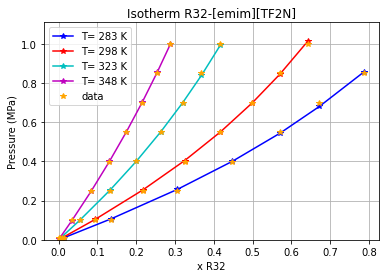

In [5]:
# for i in range(len(P)):
#     P[i] = P[i]*1e6
P1= np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

plt.plot(R32_x[0:7],P1[0:7],"b*-",label="T= 283 K")  
plt.plot(R32_x[7:15],P1[7:15],"r*-",label="T= 298 K") 
plt.plot(R32_x[15:23],P1[15:23],"c*-",label="T= 323 K") 
plt.plot(R32_x[23:31],P1[23:31],"m-*",label="T= 348 K")
plt.plot(data["x_R32"],data["pressure"]/1e6,"*",color='orange',label="data")  
plt.title('Isotherm R32-[emim][TF2N]')
plt.ylabel('Pressure (MPa)')
plt.xlabel('x R32')
plt.grid(True)
plt.ylim(0,1.110000)
plt.legend()
plt.show()

In [6]:
m.fs.F101.report()


Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value   : Fixed : Bounds
          Heat Duty :  13.828 : False : (None, None)
    Pressure Change : -2304.5 : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                               Inlet    Vapor Outlet  Liquid Outlet
    flow_mol                    1.0000      0.14045       0.85955  
    mole_frac_comp emimTf2N    0.61200   1.0000e-08       0.71200  
    mole_frac_comp R32         0.38800       1.0000       0.28800  
    temperature                 348.05       348.05        348.05  
    pressure                1.0005e+06   9.9820e+05    9.9820e+05  


In [7]:
print(P1)

[0.01064961 0.10745267 0.25723302 0.40090538 0.54353522 0.68080046
 0.85584632 0.01064106 0.10487486 0.25551701 0.4045322  0.55055264
 0.69894088 0.84499683 1.01592545 0.0088657  0.10030808 0.25430516
 0.39981677 0.55281824 0.700323   0.83891658 0.99419554 0.00559715
 0.09711048 0.24798475 0.39973795 0.55185247 0.70364424 0.8542423
 0.99819545]


In [8]:
df = pd.DataFrame(P)
df.to_csv('P_cuad.csv')